In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Chronological modelling

In [18]:
df = pd.read_csv('data/final_data_for_modelling-1.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106980 entries, 0 to 106979
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   patientid                                   106980 non-null  float64
 1   appointmentid                               106980 non-null  int64  
 2   gender                                      106980 non-null  object 
 3   scheduledday                                106980 non-null  object 
 4   appointmentday                              106980 non-null  object 
 5   age                                         106980 non-null  int64  
 6   scholarship                                 106980 non-null  int64  
 7   hypertension                                106980 non-null  int64  
 8   diabetes                                    106980 non-null  int64  
 9   alcoholism                                  106980 non-null  int64  
 

In [19]:
# ## Create new target variable -> no_show as it is the one less available in our dataset, so lets make it class 1

# df[["no_show"]] = df[["showed"]].replace({0:1, 1:0})

# print(df[["no_show"]].value_counts())
# print(df[["showed"]].value_counts())
df.drop(columns=["Neighbourhood", "scheduledday","appointmentday", 'patientid', 'appointmentid'], inplace=True)
#df.drop(columns=["showed", "neighbourhood"], inplace=True)
df.drop(columns=["age_group"] , inplace=True)

df.columns


Index(['gender', 'age', 'scholarship', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received',
       'days_between_appointment_and_scheduled_day', 'appointment_day_of_week',
       'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'windspeed',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'rating', 'no_show', 'previous_app', 'new_feat', 'train_test'],
      dtype='object')

In [20]:
# # Splitting dataset into test and train
# train = df[df["train_test"]=="train"]
# test = df[df["train_test"]=="test"]

# train.drop(columns=["train_test"], inplace=True)
# test.drop(columns=["train_test"], inplace=True)

# X_train = train.drop(columns=["no_show"]) 
# y_train = train["no_show"]
# X_test = test.drop(columns=["no_show"])
# y_test = test["no_show"]

# X_train.head()

In [21]:
df.drop(columns=["train_test"], inplace=True)

# Splitting dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["no_show"]), df["no_show"], random_state=0,test_size=0.2)

X_train.head()

,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,appointment_day_of_week,...,precipprob,windspeed,cloudcover,visibility,solarradiation,solarenergy,uvindex,rating,previous_app,new_feat
99636,F,45,1,0,0,0,0,1,33,Tuesday,...,100,3.1,68.6,4.4,144.4,12.4,6,4.9,0,0
61322,M,62,0,0,0,0,0,1,6,Tuesday,...,0,15.0,11.9,5.6,192.2,16.8,7,4.0,1,0
26778,F,17,0,0,0,0,0,0,2,Wednesday,...,0,16.1,81.4,7.1,105.0,9.0,4,3.2,2,0
40063,M,41,0,0,0,0,0,0,0,Monday,...,100,5.6,67.3,10.3,140.3,12.2,6,4.0,0,0
14917,F,64,0,0,0,0,0,0,4,Tuesday,...,100,8.7,24.0,7.1,259.9,22.6,9,4.0,3,0


In [22]:
## Ordinal encoder for features
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

## Fit encoder on train and apply to test data as well
X_train[["gender"]] = enc.fit_transform(X_train[["gender"]])
X_test[["gender"]] = enc.transform(X_test[["gender"]])

In [23]:
def onehot_encode(X, cols):
    # Treat new categories as a new 'unknown' category (all onehot columns are 0)
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[cols])
    # Get the names of the new columns created
    colnames = list(onehot_enc.get_feature_names(input_features=cols))
    # Transform the data
    onehot_vals = onehot_enc.transform(X[cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(cols,axis=1)
    return X,onehot_enc

## One hot encode the train data
cols = ["appointment_day_of_week"]
X_train, onehot_enc = onehot_encode(X_train, cols)

X_train.head()


/Users/architkaila/opt/anaconda3/envs/aipi520/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,tempmax,...,uvindex,rating,previous_app,new_feat,appointment_day_of_week_Friday,appointment_day_of_week_Monday,appointment_day_of_week_Saturday,appointment_day_of_week_Thursday,appointment_day_of_week_Tuesday,appointment_day_of_week_Wednesday
99636,0.0,45,1,0,0,0,0,1,33,69.3,...,6,4.9,0,0,0.0,0.0,0.0,0.0,1.0,0.0
61322,1.0,62,0,0,0,0,0,1,6,86.0,...,7,4.0,1,0,0.0,0.0,0.0,0.0,1.0,0.0
26778,0.0,17,0,0,0,0,0,0,2,77.4,...,4,3.2,2,0,0.0,0.0,0.0,0.0,0.0,1.0
40063,1.0,41,0,0,0,0,0,0,0,73.1,...,6,4.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
14917,0.0,64,0,0,0,0,0,0,4,81.1,...,9,4.0,3,0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Apply onehot encoder to test data
colnames = columns=list(onehot_enc.get_feature_names(input_features=cols))
onehot_vals = onehot_enc.transform(X_test[cols]).toarray()

# Put transformed data into dataframe
enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X_test.index)
# Add onehot columns back onto original dataframe and drop the original columns
X_test = pd.concat([X_test,enc_df],axis=1).drop(cols, axis=1)

X_test.head()

/Users/architkaila/opt/anaconda3/envs/aipi520/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,days_between_appointment_and_scheduled_day,tempmax,...,uvindex,rating,previous_app,new_feat,appointment_day_of_week_Friday,appointment_day_of_week_Monday,appointment_day_of_week_Saturday,appointment_day_of_week_Thursday,appointment_day_of_week_Tuesday,appointment_day_of_week_Wednesday
42063,0.0,59,0,0,0,0,0,1,14,92.4,...,9,4.4,0,0,0.0,0.0,0.0,0.0,0.0,1.0
67997,0.0,55,0,1,1,0,0,1,4,92.4,...,9,4.4,0,0,0.0,0.0,0.0,0.0,1.0,0.0
96191,0.0,40,0,0,0,0,0,0,16,80.7,...,4,4.0,2,0,1.0,0.0,0.0,0.0,0.0,0.0
46644,1.0,43,0,0,0,1,0,0,0,89.6,...,6,3.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48073,0.0,16,0,0,0,0,0,0,53,77.4,...,10,3.9,0,0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth' : [2,3,4,5],
    'min_samples_leaf': [2, 3, 4, 5],
    'n_estimators': [25, 50, 75],
    'random_state':[0],
    'criterion' :['gini', 'entropy'],
    'class_weight': [{1:4}]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                            cv = 3, n_jobs = -1, verbose = 2, scoring='precision')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=50, random_state=0; total time=   0.8s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=2, n_estimators=50, random_state=0; total time=   0.8s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=3, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight={1: 4}, criterion=gini, max_depth=2, min_samples_leaf=3, n_estimators=25, random_state=0; total time=   0.4s
[CV] END class_weight

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{1: 4}],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'n_estimators': [25, 50, 75], 'random_state': [0]},
             scoring='precision', verbose=2)

In [26]:
## params for best model
grid_search.best_params_

{'class_weight': {1: 4},
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 4,
 'n_estimators': 25,
 'random_state': 0}

In [27]:
## Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)

print("Train Report")
print(classification_report(y_train, y_pred_train))

Train Report
              precision    recall  f1-score   support

           0       0.92      0.52      0.67     68277
           1       0.30      0.82      0.44     17307

    accuracy                           0.58     85584
   macro avg       0.61      0.67      0.55     85584
weighted avg       0.79      0.58      0.62     85584



In [28]:
## test the model
y_pred_test = best_model.predict(X_test)

print("Test Report")
print(classification_report(y_test, y_pred_test))

Test Report
              precision    recall  f1-score   support

           0       0.92      0.52      0.66     17030
           1       0.31      0.82      0.45      4366

    accuracy                           0.58     21396
   macro avg       0.61      0.67      0.56     21396
weighted avg       0.80      0.58      0.62     21396



In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(y_test, y_test_prob):

    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(thresholds, precision[:-1], color='purple')
    ax.plot(thresholds, recall[:-1], color='green')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision/Recall')
    ax.set_xlabel('Threshold')

    #display plot
    plt.show()

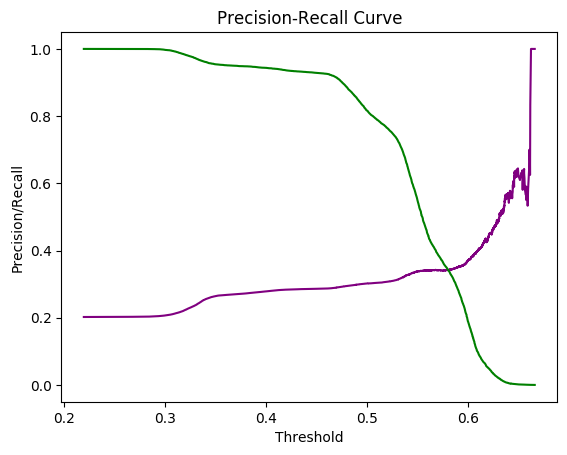

In [30]:
## Plot PR for train data
y_pred_probs = best_model.predict_proba(X_train)
y_pred_probs = y_pred_probs[:, 1]

plot_pr_curve(y_train, y_pred_probs)

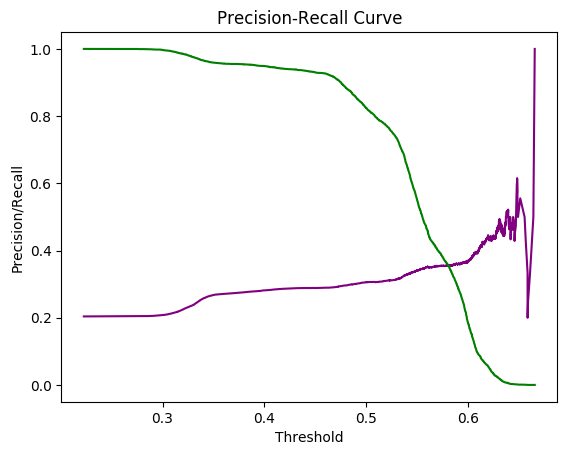

In [31]:
## Plot PR for train data
y_pred_probs = best_model.predict_proba(X_test)
y_pred_probs = y_pred_probs[:, 1]

plot_pr_curve(y_test, y_pred_probs)

In [32]:
importances = best_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances.sort_values(ascending=False)

days_between_appointment_and_scheduled_day    0.535676
sms_received                                  0.205958
age                                           0.089668
new_feat                                      0.071734
previous_app                                  0.035240
windspeed                                     0.008151
feelslikemin                                  0.005243
scholarship                                   0.005240
solarenergy                                   0.005221
solarradiation                                0.005092
tempmin                                       0.005000
humidity                                      0.004306
feelslike                                     0.004095
rating                                        0.002490
hypertension                                  0.002156
feelslikemax                                  0.002096
cloudcover                                    0.002060
visibility                                    0.001542
appointmen

## XgBoost

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

param = {"subsample":[0.7, 0.8, 0.9],
"colsample_bytree":[0.7, 0.8, 0.9],
"max_depth":[2, 3, 4],
"min_child_weight":[2, 3, 4],
"learning_rate":[0.01, 0.1, 0.05],
"n_estimators":[30, 40, 50]}


model = XGBClassifier(n_estimators=100, n_jobs=-1)
model_gs = GridSearchCV(model,param_grid=param,cv=3,scoring="f1", n_jobs=-1, verbose = 2)

model_gs.fit(X_train, y_train)
#model.fit(X_train,y_train, early_stopping_rounds=10)

model = model_gs.best_estimator_
print(model_gs.best_params_)

In [ ]:
## Train the best model
model = XGBClassifier(colsample_bytree= 0.8, learning_rate=0.2, max_depth=6,
                    min_child_weight=2, n_estimators=50, subsample=0.8, n_jobs=-1)


model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

print("Train Report")
print(classification_report(y_train, y_pred_train))



In [ ]:
## test the model
y_pred_test = model.predict(X_test)

print("Test Report")
print(classification_report(y_test, y_pred_test))